In [ ]:
# run this cell as is to install PySpark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=cc158488d8933593d74081c84976ae1e6cdf8f9986c2a4455bae24a520ad21d4
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# Start PySpark
from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'OTP_starter_phase'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .config('spark.ui.port', '4050')\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext


starting Spark


In [ ]:
# TEST write to blob storage
# Write CSV file with column header (column names)

from pyspark.sql.types import StructType,StructField, StringType, IntegerType
data2 = [("James","","Smith","36636","M",3000),
    ("Michael","Rose","","40288","M",4000),
    ("Robert","","Williams","42114","M",4000),
    ("Maria","Anne","Jones","39192","F",4000),
    ("Jen","Mary","Brown","","F",-1)
  ]

schema = StructType([ \
    StructField("firstname",StringType(),True), \
    StructField("middlename",StringType(),True), \
    StructField("lastname",StringType(),True), \
    StructField("id", StringType(), True), \
    StructField("gender", StringType(), True), \
    StructField("salary", IntegerType(), True) \
  ])

df = spark.createDataFrame(data=data2,schema=schema)
df.printSchema()
df.show(truncate=False)

# two CSV PART00000 file
df.repartition(2).write.mode('overwrite').options(header='True', delimiter=',')  \
 .csv(f"test_tmp_csv")
!ls -l test_tmp_csv # two part-0000


root
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- salary: integer (nullable = true)

+---------+----------+--------+-----+------+------+
|firstname|middlename|lastname|id   |gender|salary|
+---------+----------+--------+-----+------+------+
|James    |          |Smith   |36636|M     |3000  |
|Michael  |Rose      |        |40288|M     |4000  |
|Robert   |          |Williams|42114|M     |4000  |
|Maria    |Anne      |Jones   |39192|F     |4000  |
|Jen      |Mary      |Brown   |     |F     |-1    |
+---------+----------+--------+-----+------+------+

total 8
-rw-r--r-- 1 root root  98 Jun 14 21:07 part-00000-e5afe113-6b2e-4ba0-a406-091617550931-c000.csv
-rw-r--r-- 1 root root 138 Jun 14 21:07 part-00001-e5afe113-6b2e-4ba0-a406-091617550931-c000.csv
-rw-r--r-- 1 root root   0 Jun 14 21:07 _SUCCESS


# In Spark Learn a  linear regression via gradient descent


$$ \hat{y} = mx + b $$

Note we $\hat{y}$ as to represent a prediction or estimate of $f(x)$

$$ error_i = \hat{y_i}  - y_i$$

## Calculate the MSE for the following example in spark
**Linear Regression model prediction (in vectorized form)**


$$
\hat{y} = h_{\mathbf{\theta}}(\mathbf{X}) = \mathbf{X} \cdot \mathbf{\theta}
$$





In [ ]:
import numpy as np
# Simple linear regression
#           X             y
X_y =  [[  0.39050803,  -1.20623543],
       [  1.72151493,  13.57377242],
       [  0.82210701,   5.50818095],
       [  0.35906546,  -2.19996366],
       [ -0.61076161,  -3.90958845],
       [  1.1671529 ,  11.12900159],
       [ -0.49930231,  -3.63685934],
       [  3.13418401,  22.71362238],
       [  3.70930208,  25.53291143]]

data_rdd = sc.parallelize(X_y).cache()
# The true y = 8x - 2.
#.  [b, m]
W = [-2, 8]  # model
wBroadcast = sc.broadcast(W)  # make available in memory as read-only to the executors (for mappers and reducers)
MSE  = data_rdd.map(lambda d: (np.dot(........, wBroadcast.value) - d[-1])**2).mean()
print(f"MSE:{MSE}")


In [ ]:
import numpy as np
# Simple linear regression
#           X             y
# NON-augmented data
X_y =  [[  0.39050803,  -1.20623543],
       [  1.72151493,  13.57377242],
       [  0.82210701,   5.50818095],
       [  0.35906546,  -2.19996366],
       [ -0.61076161,  -3.90958845],
       [  1.1671529 ,  11.12900159],
       [ -0.49930231,  -3.63685934],
       [  3.13418401,  22.71362238],
       [  3.70930208,  25.53291143]]

data_rdd = sc.parallelize(X_y).cache()
# The true y = 8x - 2.
#.  [b, m]
W = [-2, 8]  # AUGMENTED model
wBroadcast = sc.broadcast(W)  # make available in memory as read-only to the executors (for mappers and reducers)
#                     (                    Xw                                   - y)**2
# gradient  (Xw - y) X
MSE  = data_rdd.map(lambda d: (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])**2).mean()
print(f"MSE:{MSE}")


MSE:5.832730881179018


In [ ]:
import numpy as np

def generate_data(w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[1] + w[0] + noise)
    X_y = np.c_[x, y]
    return X_y

# The true y = 8x - 2.  giving a weight vector of [-2, 8]
X_y = generate_data([-2, 8], 100)
X_y[:10]

array([[ 0.39050803, -1.20623543],
       [ 1.72151493, 13.57377242],
       [ 0.82210701,  5.50818095],
       [ 0.35906546, -2.19996366],
       [-0.61076161, -3.90958845],
       [ 1.1671529 , 11.12900159],
       [-0.49930231, -3.63685934],
       [ 3.13418401, 22.71362238],
       [ 3.70930208, 25.53291143],
       [-0.93246785, -7.35083934]])

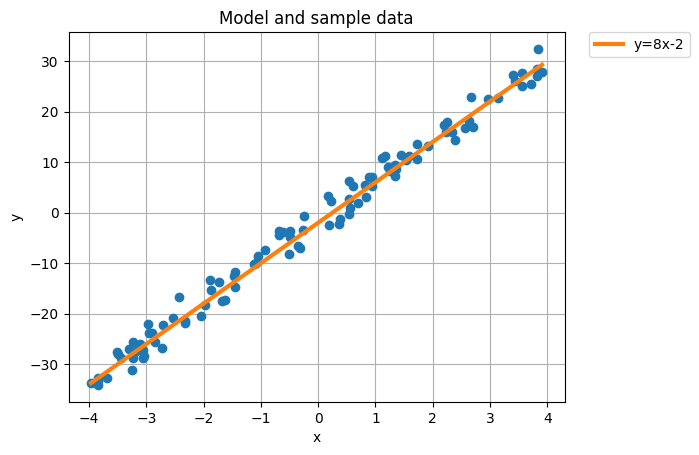

In [ ]:
# general imports
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import time
import itertools
from IPython.display import Image
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

def plot_model(samples, model, name, title=None):
    """
    Plot a model the and samples observed from the population.
    INPUT:  samples    - numpy array of points (x, y)
            model      - [W, b] where Y = Wx + b
            title      - (optional) figure title
    """

    # create plot
    fig, ax = plt.subplots()

    # plot samples
    ax.plot(X_y[:,0], X_y[:,1],'o')
    domain = [min(X_y[:,0]), max(X_y[:,0])]

    # plot model line
    w0 , w1 = model[0], model[1]
    yvals = [w1*x + w0 for x in domain]
    ax.plot(domain, yvals, linewidth=3, label=name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    # title
    if title:
        plt.title(title)
# The true y = 8x - 2.
model = [-2, 8]

# generate samples
X_y = generate_data(model, 100)

plot_model(X_y, model, 'y=8x-2', 'Model and sample data')


In [ ]:
X_y_rdd = sc.parallelize(X_y).cache()
X_y_rdd.take(5)

[array([ 0.39050803, -1.20623543]),
 array([ 1.72151493, 13.57377242]),
 array([0.82210701, 5.50818095]),
 array([ 0.35906546, -2.19996366]),
 array([-0.61076161, -3.90958845])]

In [ ]:
def compute_LR_MSE(data_rdd, W=[0,0]):
    """ compute the MSE  for the provided linear regression model W over the data RDD where each record is of the form (X, y)
    INPUT:  data_rdd    -  an RDD where each record of the form  (X,y) = data[:-1], data[-1]
            W           -  a vector of weights, where W[0] corresponds to the y-intercept

    """

    wBroadcast = sc.broadcast(W)  # make available in memory as read-only to the executors (for mappers and reducers)
    #                                                     ( Xw                    -     y)**2
    return data_rdd.map(lambda d: (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])**2).mean()

model = [0,0]
mean_squared_error = compute_LR_MSE(X_y_rdd, model)
print(f"the MSE of the  model is {model} is {mean_squared_error:.5}")

model = [-2,8]
mean_squared_error = compute_LR_MSE(X_y_rdd, model)
print(f"the MSE of the  model {model} is {mean_squared_error:.5}")

#the MSE of the  model [0, 0] is 354.35
#the MSE of the  model [-2, 8] is 4.119

the MSE of the  model is [0, 0] is 354.35
the MSE of the  model [-2, 8] is 4.119


### Quiz: Calculate the gradient

Given that MSE is calculated as follows:


$
\text{MSE}({\mathbf{\theta}}; \mathbf{X}, \mathbf{y}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{( \mathbf{x}^{(i)}\cdot \mathbf{\theta} - y^{(i)})^2}
$

which translates to the following in Spark:
```python
data_rdd.map(lambda d: (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])**2).mean()
```

Modify this code to get the gradient wrt to an example.

**Gradient vector of the cost function vectorized**

$
\begin{aligned}
\nabla_\text{MSE}(\mathbf{\theta}) &=
\begin{pmatrix}
 \frac{\partial}{\partial \theta_0} \text{MSE}(\mathbf{\theta}) \\
 \frac{\partial}{\partial \theta_1} \text{MSE}(\mathbf{\theta}) \\
 \vdots \\
 \frac{\partial}{\partial \theta_n} \text{MSE}(\mathbf{\theta})
\end{pmatrix}\\
 &= \dfrac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})\\
\nabla_\text{MSE}(\mathbf{\theta}) &= \dfrac{2}{m} x *               (\mathbf{x} \cdot \mathbf{\theta} - \mathbf{y})  \text{ for a single example}\\
\nabla_\text{MSE}(\mathbf{\theta}) &=  x *               (\mathbf{x} \cdot \mathbf{\theta} - \mathbf{y})  \text{ for a single example}
\end{aligned}
$


In [ ]:
MSE  = data_rdd.map(lambda d: (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])**2).mean()

# gradient = (Xw - y) X
# gradient  =    X         *        (               Xw             -     y)**2
gradient  = X_y_rdd.map(lambda d: ......... * (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])).mean()
print(f"gradient:{gradient}")

#### Solution to Quiz: Calculate the gradient


In [ ]:
# gradient = (Xw - y) X
# gradient  =                               X         *         (               Xw                      -     y)
gradient  = X_y_rdd.map(lambda d: np.append(1,d[:-1]) * (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])).mean()
print(f"FULL gradient:{gradient}")

FULL gradient:[-0.38466869  0.16759204]


In [ ]:
learning_rate = 0.0001

for i in range (100):
  gradient  = X_y_rdd.map(lambda d: np.append(1,d[:-1]) * (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])).mean()
  W -= learning_rate*gradient